### Stable Diffusion的组件与管道描述

In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

In [2]:
# 导入diffusers组件
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionDepth2ImgPipeline
)
from huggingface_hub import notebook_login
notebook_login()

与普通的Diffusion管线不同的是，StableDiffusion不止含有Diffusion管道中常见的UNet2DModel和调度器组件。
还包括如下组件：
- vae：可变分自编码器
- text_encoder：Transformer，对嵌入的词向量进行编码
- tokenizer：分词器
- feature_extractor：特征提取器  
通过`pipe.components.keys()`可以检查

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 载入管线
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id,revision='fp16',torch_dtype=torch.float16).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
list(pipe.components.keys())

['vae',
 'text_encoder',
 'tokenizer',
 'unet',
 'scheduler',
 'safety_checker',
 'feature_extractor']

### VAE：可变分自编码器
在SD中，VAE的作用皆在压缩原有的输入信息，之后再解码该压缩信息，得到接近输入的输出。  
其根本目的是为了减少输入的维度，从而减少UNet2DModel的计算量。
![](VAE.png)

In [6]:
# 创建取值区间为(-1,1)且满足高斯分布的伪数据
images = torch.randn(1, 3, 512, 512,dtype=torch.float16).to(device) * 2 - 1
print("input images shape:", images.shape)

input images shape: torch.Size([1, 3, 512, 512])


In [7]:
# 编码到隐空间
with torch.no_grad():
    latents = 0.18125 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

Encoded latents shape: torch.Size([1, 4, 64, 64])


In [8]:
# 从隐空间解码回来
with torch.no_grad():
    decoded = pipe.vae.decode(latents / 0.18125).sample
print("Decoded images shape:", decoded.shape)

Decoded images shape: torch.Size([1, 3, 512, 512])


### Tokenizer和Encoder：分词器和编码器
Tokenizer在SD中充当分词的作用，将输入的文本分割为若干个Token。  
而编码器部分，SD使用Transformer进行编码，最终生成一个[1,77,1024]的词向量编码。  
![](TextEncoder.png)

In [9]:
# 手动对提示词进行分词和编码
# 分词
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for id in input_ids[0]:
    print(f"{id} -> {pipe.tokenizer.decode([id])}")

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>


In [10]:
# 文本特征编码
text_embddings = pipe._encode_prompt("A painting of a flooble",device,True,'')

In [11]:
print("Text embedding shape:", text_embddings.shape)

Text embedding shape: torch.Size([1, 77, 1024])


### TokenBasedUNet2DModel：基于Token和Transformer的UNet2DModel
综上所述：在SD中，UNet的传入参数分别为：
- 来自于Transformer和Tokenizer的词向量编码，大小为[1,77,1024]
- 带有噪声的隐变量，来自于VAE，大小为[4,$\frac{H}{8}^2$]
- 时间步向量，来自于model.scheduler.timesteps  

最终输出一个[4,64,64]的噪声预测。  
<img src="./FullModel.png" width=600 height=400>

### 调度器
定义与普通Diffusion相同，不再赘述。

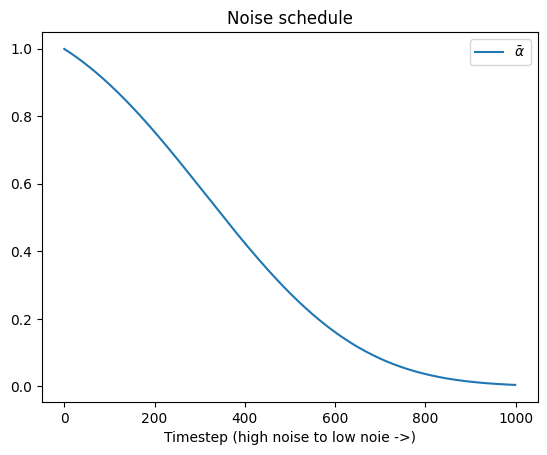

In [12]:
plt.plot(
    pipe.scheduler.alphas_cumprod,
    label = r"$\bar{\alpha}$"
)
plt.xlabel("Timestep (high noise to low noie ->)")
plt.title('Noise schedule')
plt.legend()


In [13]:
# 为Pipeline加载不同的调度器
from diffusers import LMSDiscreteScheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(
    pipe.scheduler.config,
)
# 输出配置参数
print("Scheduler config:", pipe.scheduler)

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.20.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

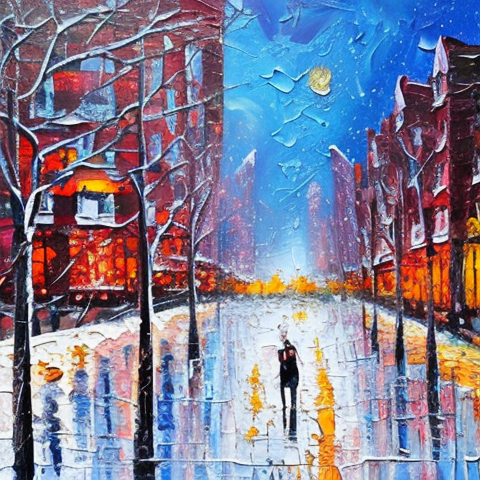

In [14]:
# 使用新的生成器来生成图片
pipe(
    prompt = "Palette knife painting of an winter cityscape",
    height=480,width=480,generator=torch.Generator().manual_seed(42)
).images[0]